# turbpy: simulating sensible heat fluxes
The sensible heat flux in land models is parameterized as:

$$
Q_h = (\theta_{air}(z) - \theta_{sfc}) C_h U(z) \rho c_p
$$
where $\theta_{air}(z)$ is the potential temperature at a height, z, above the surface, $\theta_{sfc}$ is the potential temperature of the surface (equal to the kinematic temperatue of the surface), $C_h$ is the conductance which scales the sensible heat flux according to stability, $\rho$ is the density of the air, $c_p$ is the specific heat of the air.

$C_h$ is where most of the physics of the boundary layer in land models occurs. It specifies how much turbulence is enhanced for unstable conditions and suppressed for stable conditions. This package is largely focused on the stable case, but it is capable of simulating unstable turbulence. turbpy contains a number of options for parameterizing $C_h$, but they are divided into two types: bulk aerodynamic methods and similarity theory.

## Bulk methods

In the bulk methods, the bulk Richardson number is assumed to scale the sensible heat flux.

**1) Standard/Anderson/Choudhury and Monteith (1988)/Jordan (1991)**

A bulk aerodynamic approximation to the Monin-Obukhov based stability correction of Webb (1970). These expressions are identical except for using the Obukhov length or the bulk Richardson number. Sets $Q_h$ to zero above a critical Richardson number. This number does not exist in nature. Identical to the standard method used previously in this study.

**2) Louis (unmodified)**

$$
b' = 4.7
$$

**2a) Louis (modified)**

Adjusts the b' variable to 12 from 4.7.

**2b) Louis (capped)**

Implemented the CROCUS capping where $C_h$ is set to a constant value for Ri greater than some threshold, $Ri_{st}$ such that

$$
\text{if } Ri > Ri_{st}\\
    C_h(Ri) = C_h(Ri_{st})
$$

In this implementation $Ri_{st} = 0.026$.

**3) Mahrt**

Attempts to represent the role of spatial variability in the bulk Richardson number through an empirical parameterization.

## Monin-Obukhov methods

Monin-Obukhov similarity theory assumes that turbulence scales with a dimensionless parameter. The conductance is parameterized by:

$$
C_h = k^2 / \left( (\log{\frac{z}{z_0}} - \Psi_m({\zeta})(\log{\frac{z}{z_0}} - \Psi_h({\zeta}) \right)
$$

Where $k$ is the von Karman constant, $\Psi_m$ and $\Psi_h$ are the stability corrections for momentum and heat respectively, and $z_0$ is the aerodynamic roughness, which is the height at which the surface layer of the atmosphere is assumed to start log scaling. The $z_0$ term is effectively a tunable parameter within a land model. These methods rely on the stability scaling with a dimensionless parameter, $\zeta = \frac{z}{L}$, where $z$ is the height of observations and $L$ is a "typical eddy length" but loses meaning in the stable, weak-wind boundary layer. Stability corrections are typically listed as $\phi$, which is called a gradient function, but must be converted to $\Psi$, a stability correction, for use in Monin-Obukhov similarity theory. The relationship between $\phi$ and $\Psi$ is

$$
\Psi = \int_{0}^{\zeta} \frac{1 - \phi(x)}{x}dx 
$$

In the Monin-Obukhov schemes used in turbpy, the following gradient schemes are available. Most of the parameterizations assume that $\Psi_m = \Psi_h$ even though this is likely not the case. The schemes that do not use this assumption are indicated.

**1) Holtslag and de Bruin**

A Monin-Obukhov based stability parameterization. We implement the method as described in Launiainen and vihma (1990)

This method has a critical Richardson number ($Ri_c = 1.43$)

**2) Beljaars and Holtslag**

An adjustmebnt to the Holtslag and de Bruin method. Includes the assumptions that $\Psi_H \neq \Psi_M$.

The expression for $\Psi_H$ (stability correction for heat) comes from BH91, equation 32.

$$
\Psi_H = -(1 + \frac{2}{3}a\zeta)^(\frac{3}{2}) - b(\zeta - \frac{c}{d}) e^{-d\zeta} - \frac{bc}{d} + 1 $$

to solve for the Obukhov length iteratively, I need to find $\frac{d\Psi_h}{d\zeta}$. This is the expression I've used.

$$
\frac{d\Psi_h}{d\zeta} = (b e^{-d\zeta}(d\zeta - 1 - c) - a(\frac{2a\zeta}{3} + 1)^{\frac{1}{2}}
$$

This publication describes both options 1 and 2.  
Beljaars, A. C. M., & Holtslag, A. A. M. (1991). Flux Parameterization over Land Surfaces for Atmospheric Models. Journal of Applied Meteorology. https://doi.org/10.1175/1520-0450(1991)030


**4) Cheng and Brutsaert 2005 **

A correction to the Webb method that allows turbulence during very stable conditions.


**5) Log-linear/Webb/Paulson** 

The log-linear method appears under a variety of names, but with identical form. The Anderson/standard method is assumed to approximate these MO stability functions. I explore this assumption a bit at the end of the notebook.

$$
\Psi_H = \Psi_M = -\alpha\zeta
$$

where alpha is assumed to be a constant with a value of 5. This leads to a critical Richardson number of ~0.2. We know this is non-physical. We allow $\alpha$ to be a tunable parameter.

In addition, I try to mimic CLMv4.5 and NoahMPv1.1 as closely as possible as described below.

The Webb model can be found in both CLMv4.5 and NoahMPv1.1. However, the method in CLMv4.5 has undergone substantial modifications that make it difficult to deduce what is actually inside the model. Our best attempt is included in the package, but we believe that our version is incorrect. The NoahMPv1.1 includes the Webb method in two different stability options. In this package the Webb method with the fewest modifications is included. The version included in the package includes the limit of $\zeta <= 1$, which is a hard-coded version of the Webb capping.

In NoahMP there may exist some conductance capping. If the effective conductance is below a set amount (2, but note this is not a physically meaningful value) the coductance is set to a constant. From line 3291 in module_sf_noahmplsm.F of NoahMPv1.1):

> RAHC = MAX(1.,1./(CH*UR))

The translation: the aerodynamic resistance for heat = maximum of (1, conductance for heat * horizontal wind speed).

Let's take an example value for $C_h$ from below, $C_h = 0.002$ with a wind speed of $U = 1.5$ that gives a value of 0.003. So NoahMPv1.1 effectively only uses conductance values greater than 1. Other methods include a minimum wind speed. This style of capping is not implemented as the user can provide a minimum wind speed when calling the turbpy package.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy

# OS interaction
import sys, pickle, os, yaml

# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# turbulence package
import turbpy
import turbpy.multiConst as mc

# Location of the notebook for saving the example figure.
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()

## Plot Customization

In [2]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']

# This is only relevant if you have a retina screen
%config InlineBackend.figure_format = 'retina'

## Met variables

These can be adjusted as you want.

In [3]:
sfcTemp = 265
airTemp = np.arange(260, 295, 0.25)
windspd = 2.
mHeight = 2.
z0Ground = .005
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

RiBulk = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight)

## Adjustable parameters and parameterization method

The parameter values/options listed here are identical to the default values for turbpy. If one of the parameter values is not provided to the package, it will automatically fill in the missing values with the default values. 

In [4]:
# stab_titles are the names given to each stability scheme when plotting. In this example they correspond 
# to the dictionaries that contain the parameter values for each run. T
stab_titles = ('Standard',
               'Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               'MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              )

# A mapping between the titles and the stability methods used in each test.
stab_methods = {'Standard': 'standard',
                'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

# Thes gradient functions for the Monin-Obukhov methods
gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

# Parameters for the Louis scheme. Any method without a parameter value provided 
# is filled in with the default value
params = {'Louis (b = 4.7)': 9.4,
          'Louis (Ri capped, MJ98)': 9.4,
          'Louis (b = 12)': 24.}

# Indicates which methods have capping of the conductance. Any method without capping 
# indicated is assumed to have no capping.
capping = {'Louis (Ri capped, MJ98)': 'louis_Ri_capping',
           'MO (Holtslag/de Bruin - capped)': 'windless_exchange',
          }

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]
    
    # Determine stability params
    if st in params.keys():
        stab_dict[st]['stability_params'] = {stab_methods[st]: params[st]}    

## Test Stability Functions

In [5]:
## Calculate stability

# Initialzie dictionaries for containing output
stability_correction = {}
conductance_sensible = {}
sensible_heat = {}
zeta = {}

for stab in stab_titles:
    stability_correction[stab] = np.zeros_like(RiBulk)
    conductance_sensible[stab] = np.zeros_like(RiBulk)
    sensible_heat[stab] = np.zeros_like(RiBulk)
    zeta[stab] = np.zeros_like(RiBulk)

## Calculate stability
for stab in stab_titles:
    for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):

        # Offline Turbulence Package
        (conductance_sensible[stab][n], _,
         sensible_heat[stab][n], _,
         stab_output, p_test) = turbpy.turbFluxes(tair, airPressure,
                                                  vp, windspd, sfcTemp,
                                                  sfcVaporPress, snowDepth,
                                                  mHeight, param_dict=stab_dict[stab],
                                                  z0Ground=.005)
        
        # Unpack stability parameters dictionary
        if not 'monin_obukhov' in stab_methods[stab]:
            stability_correction[stab][n] = stab_output['stabilityCorrection']
        else:
            stability_correction[stab][n] = np.nan
            zeta[stab][n] = stab_output['zeta']


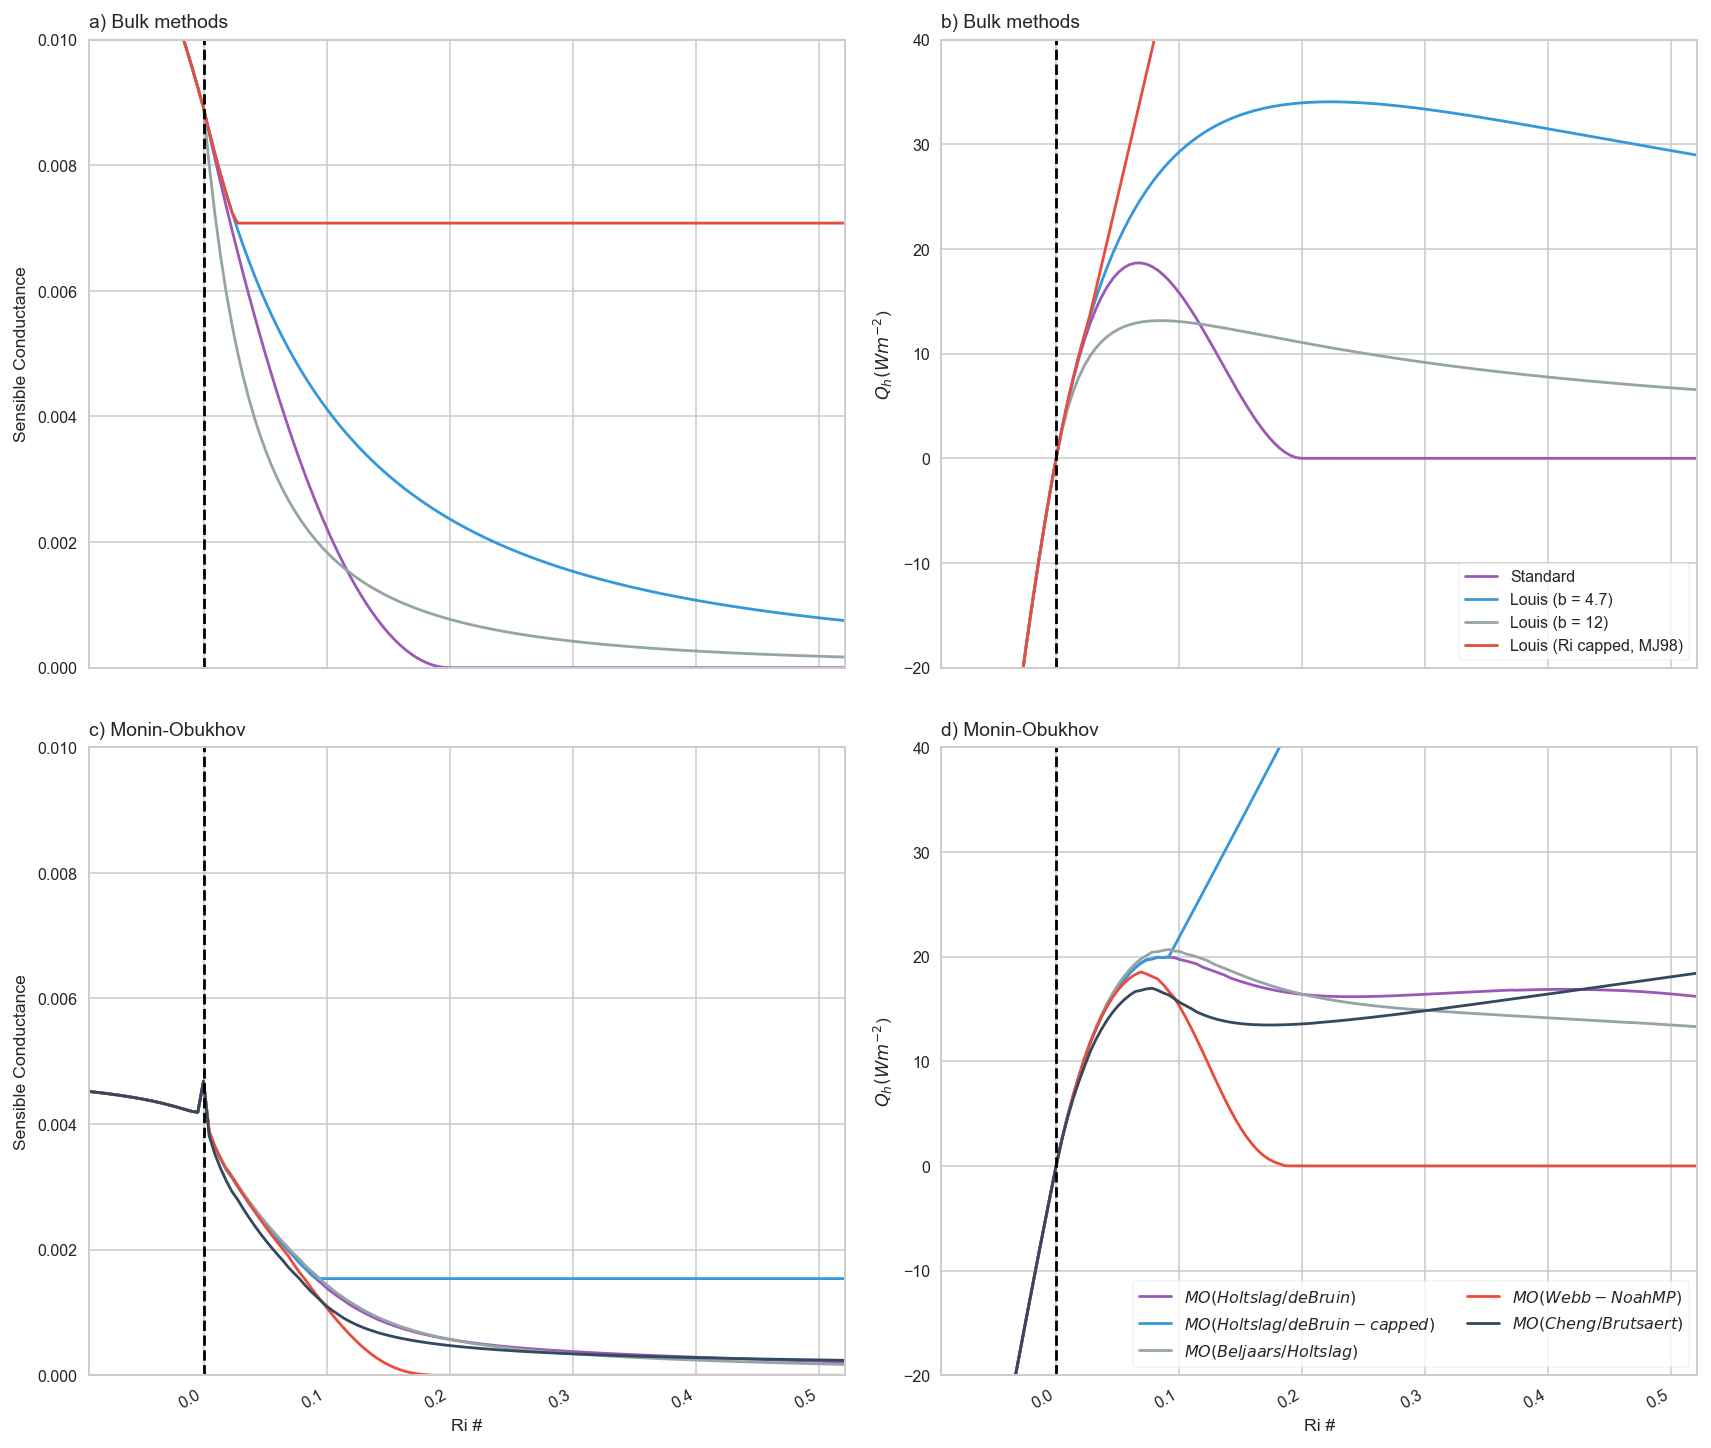

In [6]:
# Figure
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting parameters
Qmax = 40
Qmin = -20
RiMax = np.max(RiBulk)
RiMin = np.min(RiBulk)

# Bulk methods
for stab in stab_titles:
    if stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    
    # a) Bulk Conductance
    ax = axes[0]
    ax.plot(RiBulk, conductance_sensible[stab])#, color=colr[title])

    # b) Bulk Sensible Heat Flux
    ax = axes[1]
    ax.plot(RiBulk, sensible_heat[stab], label=stab)#, color=colr[title]

# Format the plots
ax = axes[0]
ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(0,0.01)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('a) Bulk methods', loc='left')


ax = axes[1]
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b) Bulk methods', loc='left')
lgd = ax.legend(loc='lower right', frameon=True)

# Monin Obukhov methods
for stab in stab_titles:
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    
    # c) MO Conductance
    ax = axes[2]
    ax.plot(RiBulk, conductance_sensible[stab])#, color=colr[title])

    # d) MO Sensible Heat Flux
    ax = axes[3]
    ax.plot(RiBulk, sensible_heat[stab], label='$' + stab + '$')#, color=colr[title]
    
# Format the plots
ax = axes[2]
ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(0,0.01)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('c) Monin-Obukhov', loc='left')

ax = axes[3]
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('d) Monin-Obukhov', loc='left')
lgd = ax.legend(loc='lower right', frameon=True, ncol=2)

fig.tight_layout()
fig.autofmt_xdate()

# Save the figure
os.chdir(workbookDir)
fig.savefig('turbpy.idealized.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)


Demonstrating the behavior of all turbpy methods. Top row is the bulk methods, bottom row is the Monin-Obukhov methods.


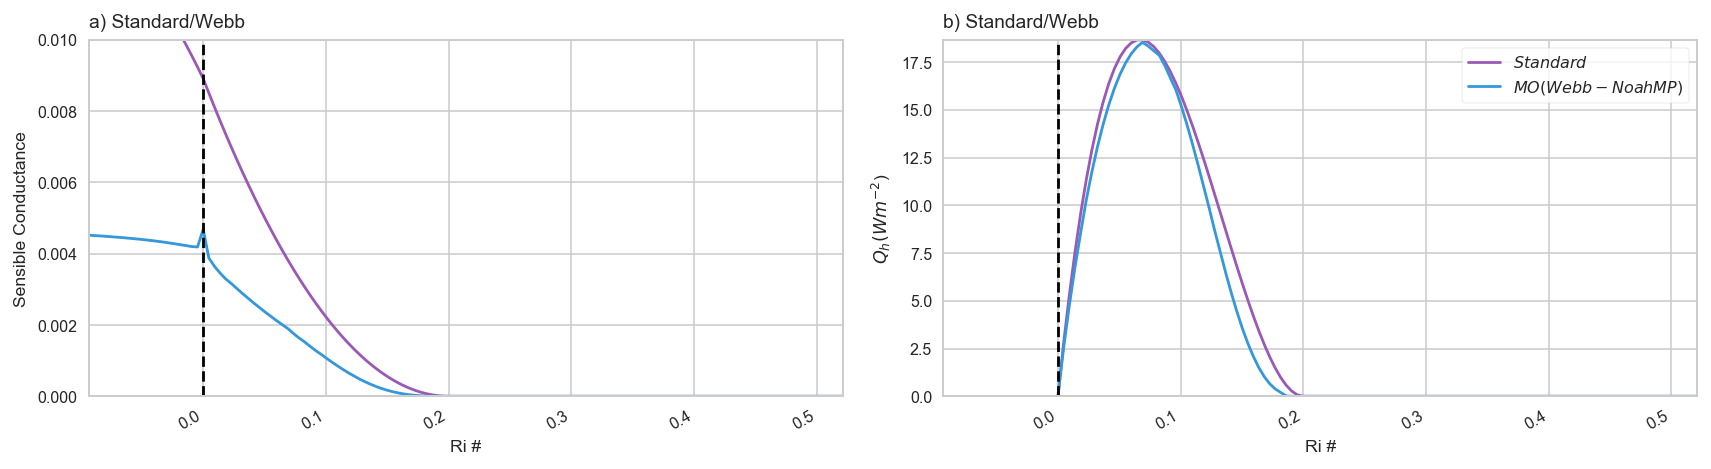

In [8]:
# Figure
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
axes = axes.flatten()

# Plotting parameters
Qmax = np.max(sensible_heat['Standard'])
Qmin = 0
RiMax = np.max(RiBulk)
RiMin = np.min(RiBulk)

# Monin Obukhov methods
for stab in stab_titles:
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        if not stab_dict[stab]['stability_method'] == 'standard':
            continue
    elif 'webb' not in stab_dict[stab]['monin_obukhov']['gradient_function']:
        continue
    
    # b) Conductance
    ax = axes[0]
    ax.plot(RiBulk, conductance_sensible[stab])#, color=colr[title])

    # c) Sensible Heat Flux
    ax = axes[1]
    ax.plot(RiBulk, sensible_heat[stab], label='$' + stab + '$')#, color=colr[title]

ax = axes[0]
ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(0,0.01)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('a) Standard/Webb', loc='left')


ax = axes[1]
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b) Standard/Webb', loc='left')
lgd = ax.legend(loc='upper right', frameon=True)

fig.tight_layout()
fig.autofmt_xdate()
os.chdir(workbookDir)
fig.savefig('turbpy.idealized_loglinear.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

Here is a comparison of the standard (bulk Richardson) and Webb (Monin-Obukhov) methods. Webb from NoahMP and the bulk Richardson "standard" method are nearly similar, which is good since they are approximated as being equivalent.